# 3.6 Reconciling projections

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.6-Reconciling-projections" data-toc-modified-id="3.6-Reconciling-projections-1">3.6 Reconciling projections</a></span><ul class="toc-item"><li><span><a href="#3.6.A-Introduction" data-toc-modified-id="3.6.A-Introduction-1.1">3.6.A Introduction</a></span></li><li><span><a href="#3.6.A.1-Requirements" data-toc-modified-id="3.6.A.1-Requirements-1.2">3.6.A.1 Requirements</a></span><ul class="toc-item"><li><span><a href="#3.6.A.2-Get-the-MODIS-LAI-datasets-for-2016/2017-for-W.-Europe" data-toc-modified-id="3.6.A.2-Get-the-MODIS-LAI-datasets-for-2016/2017-for-W.-Europe-1.2.1">3.6.A.2 Get the MODIS LAI datasets for 2016/2017 for W. Europe</a></span></li><li><span><a href="#3.6.A.3-Get-the-shapefile-for-country-borders" data-toc-modified-id="3.6.A.3-Get-the-shapefile-for-country-borders-1.2.2">3.6.A.3 Get the shapefile for country borders</a></span></li><li><span><a href="#3.6.A.4-Read-the-LAI-dataset-for-a-given-country-and-year" data-toc-modified-id="3.6.A.4-Read-the-LAI-dataset-for-a-given-country-and-year-1.2.3">3.6.A.4 Read the LAI dataset for a given country and year</a></span></li><li><span><a href="#3.6.A.5-register-with-ECMWF-and-install-the-API" data-toc-modified-id="3.6.A.5-register-with-ECMWF-and-install-the-API-1.2.4">3.6.A.5 register with ECMWF and install the API</a></span></li><li><span><a href="#3.6.2.4-Get-the-2t-dataset-from-ECMWF-for-Europe" data-toc-modified-id="3.6.2.4-Get-the-2t-dataset-from-ECMWF-for-Europe-1.2.5">3.6.2.4 Get the 2t dataset from ECMWF for Europe</a></span></li><li><span><a href="#3.6.2.5-Generate-dataset-wkt-and-correct-ECMWF-file" data-toc-modified-id="3.6.2.5-Generate-dataset-wkt-and-correct-ECMWF-file-1.2.6">3.6.2.5 Generate dataset wkt and correct ECMWF file</a></span></li><li><span><a href="#3.6.2.6-Get-land-cover-data" data-toc-modified-id="3.6.2.6-Get-land-cover-data-1.2.7">3.6.2.6 Get land cover data</a></span></li></ul></li></ul></li></ul></div>

## 3.6.A Introduction

This section of notes is optional to the course, and the tutor may decide *not* to go through this in class. That said, the information and obexamples contained here can be very useful for accessing and processing certain types of geospatial data.

In particular, we deal with obtaining climate data records from [ECMWF](http://apps.ecmwf.int/datasets/data/era40-daily/levtype=sfc) that we will later use for model fitting. These data come in a [netcdf](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) format (commonly used for climate data) with a grid in latitude/longitude. To 'overlay' these data with another dataset (e.g. the MODIS LAI product that we have been using) in a different (equal area) projection, we use the `gdal` function

    gdal.ReprojectImage(src, dst, src_proj, dst_proj, interp)
       
where:

    src      : a source dataset that we want to process 
    dst      : a blank destination dataset that we set up with the 
               required (output) data type, shape, and geotransform and projection
    src_proj : the source dataset projection wkt 
    dst_proj : the destination projection wkt 
    interp   : the required interpolation method, e.g. gdalconst.GRA_Bilinear
    
where wkt stands for [well known text](https://en.wikipedia.org/wiki/Well-known_text) and is a projection format string.

Other codes we use are ones we have developed earlier.

In these notes, we will learn:

    * how to access an ECMWF daily climate dataset (from ERA interim)
    * how to reproject the dataset to match another spatial dataset (MODIS LAI)
    
We will then save some datasets that we will use later in the notes. For this reason, it's possile to skip this section, and return to it later.

## 3.6.A.1 Requirements

We will need to:

* make sure we have the MODIS LAI dataset locally
* read them in for a given country.
* generate and interpolated LAI dataset
* register with ecmwf, install ecmwfapi
* get the temperature datasset from ECMWF for 2006 and 2017 for Europe
* get the country borders shapefile

In [1]:
# required general imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
from pathlib import Path
import gdal
from datetime import datetime, timedelta
year = 2016
country_code = 'LU'

You can run all of the below with the script, unless you want to change any of the conditions (e.g. year or country):

In [2]:
# This does the same as the cells below but in one script
%run geog0111/Chapter3_6A_prerequisites.py $country_code $year

['geog0111/Chapter3_6A_prerequisites.py', 'LU', '2016'] 2016 LU
europe_data_2016_2017.nc exists
GEOGCS["Coordinate System imported from GRIB file",DATUM["unknown",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]
Refreshing nc file europe_data_2016_2017.nc
data/europe_data_2016.nc
data/europe_data_2017.nc
Running outside UCL Geography. Will try to download data.
 landcover_data_2017_LU.npz 
This might take a while!
trying http://www2.geog.ucl.ac.uk/~plewis/geog0111_data/lai_files/
trying http://www2.geog.ucl.ac.uk/~plewis/geog0111_data/
trying http://www2.geog.ucl.ac.uk/~ucfajlg/geog0111_data/
server may be down


### 3.6.A.2 Get the MODIS LAI datasets for 2016/2017 for W. Europe

You will probably already have this dataset, but running the code below will make sure that you do.

In [3]:
# get the MODIS LAI dataset for 2016/2017 for W. Europe
# should be 736 files 
from geog0111.geog_data import procure_dataset
from pathlib import Path

num_hdf = len(list(Path('data').glob('MCD15A3H*hdf')))
if num_hdf < 736:
    _ = procure_dataset("lai_files",verbose=False)

### 3.6.A.3 Get the shapefile for country borders

Again, you should already have this, but just to make sure:

In [4]:
import requests
import shutil
from pathlib import Path

force = False
# zip file
zipfile = 'TM_WORLD_BORDERS-0.3.zip'
# URL
tm_borders_url = f"http://thematicmapping.org/downloads/{zipfile}"
# destibnation folder
destination_folder = Path('data')

# set up some filenames
zip_file = destination_folder.joinpath(zipfile)
shape_file = zip_file.with_name(zipfile.replace('zip', 'shp'))

# download zip if need to
if not Path(zip_file).exists():
    r = requests.get(tm_borders_url)
    with open(zip_file, 'wb') as fp:
        fp.write(r.content)

# extract shp from zip if need to
if force or not Path(shape_file).exists():
    shutil.unpack_archive(zip_file.as_posix(), extract_dir=destination_folder)
    

### 3.6.A.4 Read the LAI dataset for a given country and year

Run the code below to read in the LAI dataset for a given year and country. This uses codes we have developed in previous sections, interfaced through `process_timeseries()`.

In the code, we can save the dataset as an `npz` file, so that we can access it faster next time.

In [5]:
# read in the LAI data for given country code
from geog0111.process_timeseries import process_timeseries
import scipy
import scipy.ndimage.filters
'''
Note, the saved npz file can be quite large
e.g. 8.1 G for France.

You can override saving it by setting save = False
but if it is saved, it will be faster to access
data the next time you need it.

If you have a slow network, you might set download=False

Does interpolation of dataset with Gaussian smoother width sigma
'''
save = True
download = True
# want sigma as low as we can deal with, whilst 
# still interpolating effectively
sigma = 3


tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
done = False

if ofile.exists():
    done = True
    
# try to download it from server
if download:
    done = procure_dataset(fname,verbose=True)

if not done:
    # else generate it
    dates, lai_array, weights_array = process_timeseries(year,tiles,frmat='MEM',\
                                                     country_code=country_code)
 
    lai = {'dates':dates, 'lai':lai_array, 'weights':weights_array}

    # set up filter
    x = np.arange(-3*sigma,3*sigma+1)
    gaussian = np.exp((-(x/sigma)**2)/2.0)

    FIPS = country_code
    dates, lai_array, weights_array = lai['dates'],lai['lai'],lai['weights']
    print(lai_array.shape, weights_array.shape) #Check the output array shapes
    print('interpolating ...')
    numerator = scipy.ndimage.filters.convolve1d(lai_array * weights_array, gaussian, axis=2,mode='wrap')
    denominator = scipy.ndimage.filters.convolve1d(weights_array, gaussian, axis=2,mode='wrap')

    # avoid divide by 0 problems by setting zero values
    # of the denominator to not a number (NaN)
    denominator[denominator==0] = np.nan

    interpolated_lai = numerator/denominator
    print(interpolated_lai.shape)

    # need to convert to dict to be able to assign
    lai['interpolated_lai'] = interpolated_lai
    print('saving ...')
    if save:
        np.savez_compressed(ofile,**lai)

In [6]:
# test that LAI is sensible
# a quick look at some stats to see if there are data there
# and they are sensible
lai = np.load(ofile)
print(np.nanmean(lai['lai'],axis=(0,1)))
print(np.nanmean(lai['weights'],axis=(0,1)))
# does it have the interpolated value?
if 'interpolated_lai' in list(lai.keys()):
    print(np.nanmean(lai['interpolated_lai'],axis=(0,1)))

[12.46488359 12.9707779  12.66668052 12.57172487 12.5430109  12.38457132
 12.23579545 12.27250554 12.26942905 12.43250647 12.48960643 12.60697062
 12.57322154 12.36961382 12.51265244 12.52181264 12.50411123 12.66635717
 12.75169531 12.26231061 12.86824649 12.99491408 12.97218681 13.04568551
 13.2463969  13.28130081 12.77618718 13.17412232 12.98403548 13.40995935
 12.5675813  12.53988821 13.8197755  14.04873891 13.772949   13.5904102
 14.19393016 13.86867609 13.686165   13.58825758 14.10188008 13.86718404
 13.85474409 13.53060329 13.50408814 13.1711105  13.75550166 13.87436253
 13.7763119  13.36458333 13.30586197 13.46170085 13.10407428 13.24387934
 13.86328529 13.04242424 13.41308666 12.96385347 13.70315503 13.45206486
 13.80310421 13.93165188 12.91742886 13.32721268 13.45185698 13.4931772
 13.83985588 13.49764412 13.10169993 12.66001016 12.77271803 13.33361511
 13.03124076 12.59559775 12.72172949 12.95489191 12.98522265 12.38168422
 12.22975795 12.65463784 12.55263766 13.11926275 12.8

### 3.6.A.5 register with ECMWF and install the API

Follow the [ECMWF instructions](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets)

First, you should [register as a user with ECMWF](https://apps.ecmwf.int/auth/login).

The first time:

* register and follow the emailed instructions.

* read and acknowledge the [conditions of access and related information](https://www.ecmwf.int/en/computing/access-computing-facilities/conditions-access-ecmwf-computing-services).

* follow the instructions on [how to access datasets](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets) to receive and set up [an ECMWF key](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets#AccessECMWFPublicDatasets-key)

Help is available [online](https://confluence.ecmwf.int/display/UDOC/User+Documentation).

In [7]:
# install ecmwf api -- do this once only
ECMWF = 'https://software.ecmwf.int/wiki/download/attachments/56664858/ecmwf-api-client-python.tgz'
try:
    from ecmwfapi import ECMWFDataServer
except:
    import os
    if os.name == 'nt':
        # on windows
        !pip install $ECMWF
    else:
        # on Unix/Linux
        !pip install --user $ECMWF

### 3.6.2.4 Get the 2t dataset from ECMWF for Europe

Run the code below to request and download the daily 2m temperature dataset for 2016 and 2017 (0.25 degree resolution) from the ECMWF ERA interim data.

If the file already exists locally, the request will be ignored.

If you do need to run the request, it may take several hours, depending on the ECMWF queue at the time.

In [8]:
from ecmwfapi import ECMWFDataServer
from pathlib import Path
from geog0111.geog_data import procure_dataset

ecmwf_file = 'europe_data_2016_2017.nc'

if not (Path('data')/ecmwf_file).exists():
    # try to get it from UCL servers
    done = procure_dataset(ofile,verbose=True)
    if not done:
        server = ECMWFDataServer()
        print('requesting data ... may take some time')
        server.retrieve({
            "class": "ei",
            "dataset": "interim",
            "date": "2016-01-01/to/2017-12-31", # Time period
            "expver": "1",
            "levtype": "sfc",
            "param": "2t",           # Parameters. Here we use 2m Temperature (2t)  See the ECMWF parameter database, at http://apps.ecmwf.int/codes/grib/param-db
            "stream": "oper",
            "type": "an",
            "time": "12",
            "step": "0",
            "area": "75/-20/10/60",    # Subset or clip to an area, here to Europe. Specify as North/West/South/East in Geographic lat/long degrees. Southern latitudes and Western longitudes must be given as negative numbers.
            "grid": "0.25/0.25",        # Regrid from the default grid to a regular lat/lon with specified resolution. The first number is east-west resolution (longitude) and the second is north-south (latitude).
            "format": "netcdf",         # Convert the output file from the default GRIB format to NetCDF format. Requires "grid" to be set to a regular lat/lon grid.
            "target": f"data/{ecmwf_file}",  # The output file name. Set this to whatever you like.
        })
else: print(f'{ecmwf_file} exists')

europe_data_2016_2017.nc exists


### 3.6.2.5 Generate dataset wkt and correct ECMWF file

The coordinate system of the ECMWF is peculiar in that it has a non-standard Earth spheroid.

According to [ECMWF](https://confluence.ecmwf.int/plugins/servlet/mobile?contentId=56658069#content/view/56658069), the 
Earth model assumed for GRIB data (and inherited for other data products) uses a sphere with radius 6367.47 km, as defined in the [WMO GRIB Edition 1 specifications, Table 7, GDS Octet 17](http://www.wmo.int/pages/prog/www/WMOCodes/Guides/GRIB/GRIB1-Contents.html).

We will mostly be dealing with netcdf files, as above. But it is not straightforward to get this projection information from the netcdf file.

Instead, we access an example grib format file and save it as `data/Pacific.wind.7days.grb`. We then generate a wkt (well known text) format file [`data/grb.wkt`](data/grb.wkt) and insert this into the file using `gdal.Translate()`.

The code below is quite complicated, buit needed to fix file format problems. It also converts the integer data into physical units (temperature in K) using the `-unscale` option.

In [9]:
from osgeo import gdal
import requests
from pathlib import Path
import numpy as np
from datetime import datetime,timedelta

# download example grib file from
url = "http://gribs2.gmn-usa.com/cgi-bin/" +\
        "weather_fetch.pl?parameter=wind&days=7&region=Pacific&dataset=nww3"
ofile = 'data/Pacific.wind.7days.grb'
overwrite = False

# get the example grib datafile
# see
# https://gis.stackexchange.com/questions/
# 289314/using-gdal-to-read-data-from-grib-file-in-python
output_fname = Path(ofile)
with requests.Session() as session:
    r1 = session.request('get',url)
    if r1.url:
        r2 = session.get(r1.url)
        data = r2.content
        d = 0
        if overwrite or (not output_fname.exists()):  
            with open(output_fname, 'wb') as fp:
                d = fp.write(data)

dataset = gdal.Open(ofile)
wkt = dataset.GetProjection()
with open('data/grb.wkt', 'w') as fp:
    # write wkt to file
    d = fp.write(wkt)
    
# use this to fix the downloaded file
# which is ecmwf_file
ifile = f"data/{ecmwf_file}"

# need to sort the metadata
meta = gdal.Open(ifile).GetMetadata()
# get time info
timer = np.array([(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')])

# pull the years info from ifile
# if the file is multiple years eg europe_data_2010_2011.nc
# then split it into multiple files
years = np.array(Path(ifile).stem.split('_'))[2:].astype(int)

# filter data for required year

for year in years:
    ofile = f'data/europe_data_{year}.nc'
    mask = np.logical_and(timer >= datetime(year,1,1),timer <= datetime(year+1,1,1))
    timer2 = timer[mask]
    bands = ' '.join([f'-b {i}' for i in (np.where(mask)[0]+1)])    
    timer3 = '{'+','.join(np.array(meta['NETCDF_DIM_time_VALUES'][1:-1].split(','))[mask])+'}'
    timer4 = '{'+str(mask.sum())+',4}'
    options = f"-of netcdf -unscale -ot Float32 {bands} -mo NETCDF_DIM_time_VALUES={timer3}" + \
              f" -mo NETCDF_DIM_time_DEF={timer4} -a_srs data/grb.wkt"
    gdal.Translate(ofile+'tmp',ifile,options=options)
    Path(ofile+'tmp').replace(ofile)
    print(ofile)

data/europe_data_2016.nc
data/europe_data_2017.nc


In [10]:
from osgeo import gdal
import requests
from pathlib import Path
import numpy as np

'''
Get the SRS 6974 for MODIS in case we want to use it
'''

url = 'http://spatialreference.org/ref/sr-org/6974/ogcwkt/'
ofile = 'data/modis_6974.wkt'
overwrite = False

# http://spatialreference.org/ref/sr-org/6974
output_fname = Path(ofile)
with requests.Session() as session:
    r1 = session.request('get',url)
    if r1.url:
        r2 = session.get(r1.url)
        data = r2.text
        d = 0
        if overwrite or (not output_fname.exists()):  
            with open(output_fname, 'w') as fp:
                d = fp.write(data)

# test opening it
wkt2 = open(ofile,'r').readlines()

print(wkt2)

['PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",0.0],PARAMETER["semi_major",6371007.181],PARAMETER["semi_minor",6371007.181],UNIT["m",1.0],AUTHORITY["SR-ORG","6974"]]']


### 3.6.2.6 Get land cover data

The MODIS land cover product [MCD12Q1](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd12q1_v006) we need is on the server:

    https://e4ftl01.cr.usgs.gov//MODV6_Cmp_C/MOTA/
    
This is an annual dataset, with access date `YYYY.01.01`.

We will use

    Land Cover Type 3: Annual Leaf Area Index (LAI) classification
    
referenced as `"LC_Type3"` (valid range 0 to 10).

This is interpreted as:


| Name | Value | Description |  
|------|-------|-------------|
|Water Bodies|0|At least 60% of area is covered by permanent water bodies.|
|Grasslands|1|Dominated by herbaceous annuals (<2m) includ- ing cereal croplands.|
|Shrublands|2|Shrub (1-2m) cover >10%.|
|Broadleaf Croplands|3|Dominated by herbaceous annuals (<2m) that are cultivated with broadleaf crops.|
|Savannas|4|Between 10-60% tree cover (>2m).|
|Evergreen Broadleaf Forests|5|Dominated by evergreen broadleaf and palmate trees (>2m). Tree cover >60%.|
|Deciduous Broadleaf Forests|6|Dominated by deciduous broadleaf trees (>2m). Tree cover >60%.|
|Evergreen Needleleaf Forests|7|Dominated by evergreen conifer trees (>2m). Tree cover >60%.|
|Deciduous Needleleaf Forests|8|Dominated by deciduous needleleaf (larch) trees (>2m). Tree cover >60%.|
|Non-Vegetated Lands|9|At least 60% of area is non-vegetated barren (sand, rock, soil) or permanent snow and ice with less than 10% vegetation.|
|Urban and Built-up Lands|10|At least 30% impervious surface area including building materials, asphalt, and vehicles.|
|Unclassified|255|Has not received a map label because of missing inputs.|

In [11]:
from geog0111.get_modis_files import get_modis_files
'''
Get the MODIS LC files from the server
to store in data
'''
try:
    url = 'https://e4ftl01.cr.usgs.gov//MODV6_Cmp_C/MOTA/'
    filename = get_modis_files(1,year,[tiles],base_url=url,\
                                               version=6,verbose=True,\
                                               destination_folder='data',\
                                               product='MCD12Q1')[0]
    print(filename)
except:
    print('server may be down')

server may be down


In [12]:
from geog0111.process_timeseries import mosaic_and_clip

'''
Extract and clip the dataset
'''
lc_data = mosaic_and_clip(tiles,
                    1,
                    year,
                    folder='data',
                    layer="LC_Type3",
                    shpfile='data/TM_WORLD_BORDERS-0.3.shp',
                    country_code=country_code,
                    product='MCD12Q1',
                    frmat="MEM")

In [13]:
'''
Define LC table from userguide
https://lpdaac.usgs.gov/sites/default/\
        files/public/product_documentation/\
        mcd12_user_guide_v6.pdf
'''

table = '''
|Water Bodies|0|At least 60% of area is covered by permanent water bodies.|
|Grasslands|1|Dominated by herbaceous annuals (<2m) includ- ing cereal croplands.|
|Shrublands|2|Shrub (1-2m) cover >10%.|
|Broadleaf Croplands|3|Dominated by herbaceous annuals (<2m) that are cultivated with broadleaf crops.|
|Savannas|4|Between 10-60% tree cover (>2m).|
|Evergreen Broadleaf Forests|5|Dominated by evergreen broadleaf and palmate trees (>2m). Tree cover >60%.|
|Deciduous Broadleaf Forests|6|Dominated by deciduous broadleaf trees (>2m). Tree cover >60%.|
|Evergreen Needleleaf Forests|7|Dominated by evergreen conifer trees (>2m). Tree cover >60%.|
|Deciduous Needleleaf Forests|8|Dominated by deciduous needleleaf (larch) trees (>2m). Tree cover >60%.|
|Non-Vegetated Lands|9|At least 60% of area is non-vegetated barren (sand, rock, soil) or permanent snow and ice with less than 10% vegetation.|
|Urban and Built-up Lands|10|At least 30% impervious surface area including building materials, asphalt, and vehicles.|
|Unclassified|255|Has not received a map label because of missing inputs.|
'''

LC_Type3 = np.array([s.split('|')[1:-1] for s in table.split('\n')[1:-1]]).T
    

np.savez_compressed(f'data/landcover_{year}_{country_code}.npz',
                   LC_Type3=LC_Type3,lc_data=lc_data)

['Grasslands' 'Broadleaf Croplands' 'Savannas'
 'Evergreen Broadleaf Forests' 'Deciduous Broadleaf Forests'
 'Evergreen Needleleaf Forests' 'Urban and Built-up Lands']


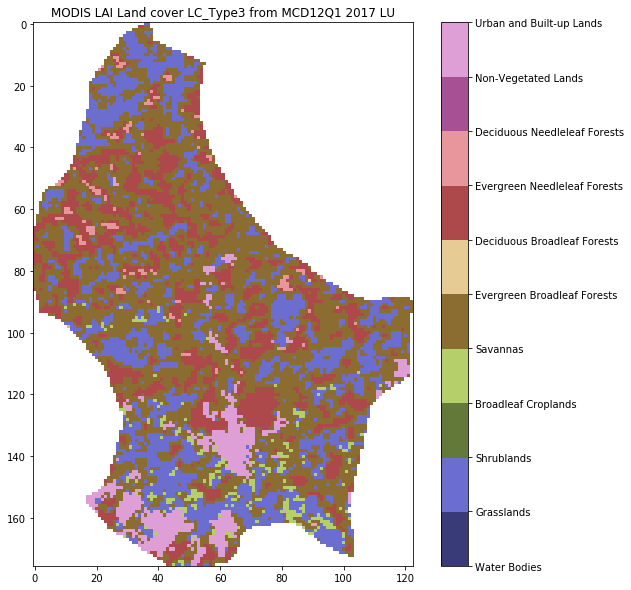

In [21]:
# Unique values for "LC_Type3"
def plot_land_cover(lc_data,year,country_code,cmap='tab20b'):
    '''
    Define LC table from userguide
    https://lpdaac.usgs.gov/sites/default/\
            files/public/product_documentation/\
            mcd12_user_guide_v6.pdf
    '''

    table = '''
    |Water Bodies|0|At least 60% of area is covered by permanent water bodies.|
    |Grasslands|1|Dominated by herbaceous annuals (<2m) includ- ing cereal croplands.|
    |Shrublands|2|Shrub (1-2m) cover >10%.|
    |Broadleaf Croplands|3|Dominated by herbaceous annuals (<2m) that are cultivated with broadleaf crops.|
    |Savannas|4|Between 10-60% tree cover (>2m).|
    |Evergreen Broadleaf Forests|5|Dominated by evergreen broadleaf and palmate trees (>2m). Tree cover >60%.|
    |Deciduous Broadleaf Forests|6|Dominated by deciduous broadleaf trees (>2m). Tree cover >60%.|
    |Evergreen Needleleaf Forests|7|Dominated by evergreen conifer trees (>2m). Tree cover >60%.|
    |Deciduous Needleleaf Forests|8|Dominated by deciduous needleleaf (larch) trees (>2m). Tree cover >60%.|
    |Non-Vegetated Lands|9|At least 60% of area is non-vegetated barren (sand, rock, soil) or permanent snow and ice with less than 10% vegetation.|
    |Urban and Built-up Lands|10|At least 30% impervious surface area including building materials, asphalt, and vehicles.|
    |Unclassified|255|Has not received a map label because of missing inputs.|
    '''

    LC_Type3 = np.array([s.split('|')[1:-1] for s in table.split('\n')[1:-1]]).T
    
    
    '''
    First, lets get the codes and names of the LCs used
    '''
    flc_data = lc_data.astype(float)
    flc_data[lc_data == 255] = np.nan
    land_covers_present = np.unique(lc_data[lc_data!=255])
    land_cover_names = LC_Type3[0]
    '''
    For categorical data we want a quantitative colormap

    The core options are:
    https://matplotlib.org/tutorials/colors/colormaps.html

    qcmaps = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
             'Dark2', 'Set1', 'Set2', 'Set3',
              'tab10', 'tab20', 'tab20b', 'tab20c']
    '''

    '''
    Now learn how to plot with categorical labels
    following example in
    https://gist.github.com/jakevdp/8a992f606899ac24b711
    FuncFormatter to put labels 
    '''

    ncov = land_covers_present.max()
    # This function formatter will replace integers with target names
    formatter = plt.FuncFormatter(lambda val, loc: land_cover_names[val])
    plt.figure(figsize=(10,10))
    plt.title(f'MODIS LAI Land cover LC_Type3 from MCD12Q1 {year} {country_code}')
    plt.imshow(flc_data,vmax=ncov,vmin=0,\
               cmap=plt.cm.get_cmap(cmap,ncov))
    plt.colorbar(ticks=np.arange(ncov+2).astype(int), \
                 format=formatter)
    return(land_cover_names[land_covers_present])
    
from geog0111.plot_landcover import plot_land_cover
print(plot_land_cover(lc_data,year,country_code))

Dominated by herbaceous annuals (<2m) includ- ing cereal croplands.


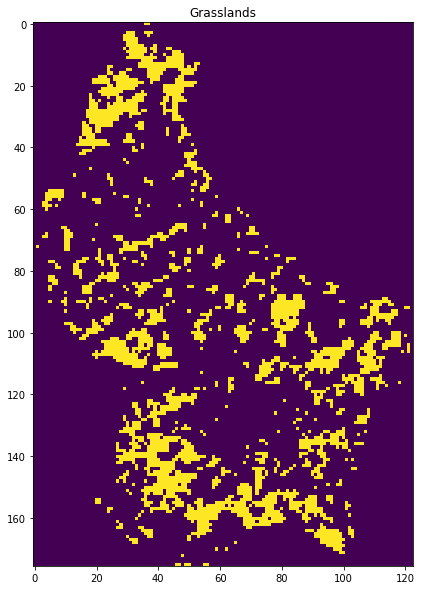

In [26]:
lc = 1

flc_data = lc_data.astype(float)
flc_data[lc_data != lc] = np.nan
plt.figure(figsize=(10,10))
plt.imshow(flc_data.astype(int))
plt.title(LC_Type3[0,lc])
print(LC_Type3[2,lc])

In [15]:
# uncomment to run all LCs
_='''for year in [2016,2017]:
    for country_code in ['BE','DA','EI','FR','GM','IM','LU','NL','SP','SZ','UK']:
        %run geog0111/get_landcover.py $country_code $year'''